In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'))
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_n_5_0,ast_ngram_n_5_1,ast_ngram_n_5_2,ast_ngram_n_5_3,ast_ngram_n_5_4,ast_ngram_n_5_5,ast_ngram_n_5_6,ast_ngram_n_5_7,ast_ngram_n_5_8,ast_ngram_n_5_9
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1,1,1,1.00,...,1,1,1,1,1,1,1,1,1,1
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1,1,1,1.00,...,1,1,0,1,0,1,0,1,1,1
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1,1,1,0.00,...,1,0,0,0,0,0,0,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1,1,1,0.00,...,1,1,1,1,1,1,1,1,1,1
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1,1,1,0.25,...,1,1,0,1,1,1,1,1,1,1


In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df

model_path = '../models/cv_fitness_model_2023_02_02.pkl.gz'
data_df = fitness_df

with gzip.open(model_path, 'rb') as f:
    cv_energy_model = pickle.load(f)

feature_columns = [c for c in data_df.columns if c not in NON_FEATURE_COLUMNS]


## Histogram the weights to get a sense of what we're dealing with

Weights mean: 0.0365, std: 0.2148, bias: 0.4492


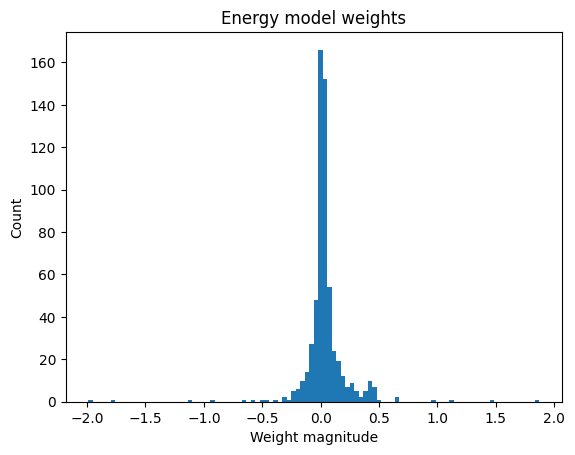

In [6]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=100)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

## Print the top K features most and least predictive of real games

In [7]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games:')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games:')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games:
1. all_variables_used (-1.9895)
2. variable_not_repeated (-1.7671)
3. pref_forall_used (-1.1281)
4. pref_forall_correct_types (-0.9110)
5. all_variables_defined (-0.6387)
6. in_arg_types_receptacles_balls_constraints (-0.5969)
7. all_preferences_used (-0.4905)
8. no_nested_logicals (-0.4509)
9. pref_forall_correct_arity (-0.3843)
10. compositionality_structure_5 (-0.3104)
11. text_ngram_n_5_5 (-0.2944)
12. text_ngram_n_5_8 (-0.2759)
13. compositionality_structure_6 (-0.2492)
14. no_two_number_operations (-0.2429)
15. text_ngram_n_5_9 (-0.2426)
16. text_ngram_n_5_7 (-0.2193)
17. on_arg_types_furniture_any_object_constraints (-0.2165)
18. ast_ngram_n_3_9 (-0.2070)
19. text_ngram_n_2_4 (-0.1942)
20. ast_ngram_n_4_5 (-0.1874)
### Features with largest positive weights (most predictive of fake games:
1. text_ngram_n_5_score (1.8718)
2. text_ngram_n_4_score (1.4757)
3. text_ngram_n_3_score (1.1100)
4. redundant_expression_found (0.9791)
5. in_motion_arg_types_receptacles_constraints (0.6745)
6. text_ngram_n_2_score (0.6564)
7. ast_ngram_n_5_score (0.5008)
8. agent_holds_arg_types_receptacles_constraints (0.4729)
9. text_ngram_n_3_1 (0.4619)
10. text_ngram_n_2_9 (0.4619)
11. ast_ngram_n_3_0 (0.4595)
12. ast_ngram_n_2_7 (0.4511)
13. ast_ngram_n_2_1 (0.4474)
14. ast_ngram_n_2_0 (0.4474)
15. correct_predicate_function_arity (0.4423)
16. ast_ngram_n_5_0 (0.4420)
17. text_ngram_n_3_0 (0.4412)
18. text_ngram_n_2_3 (0.4396)
19. text_ngram_n_2_2 (0.4345)
20. ast_ngram_n_4_1 (0.4324)

## Plot a histogram of the values for each of the and bottom K features

In [8]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    columns = [c for c in df.columns if c not in NON_FEATURE_COLUMNS]
    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

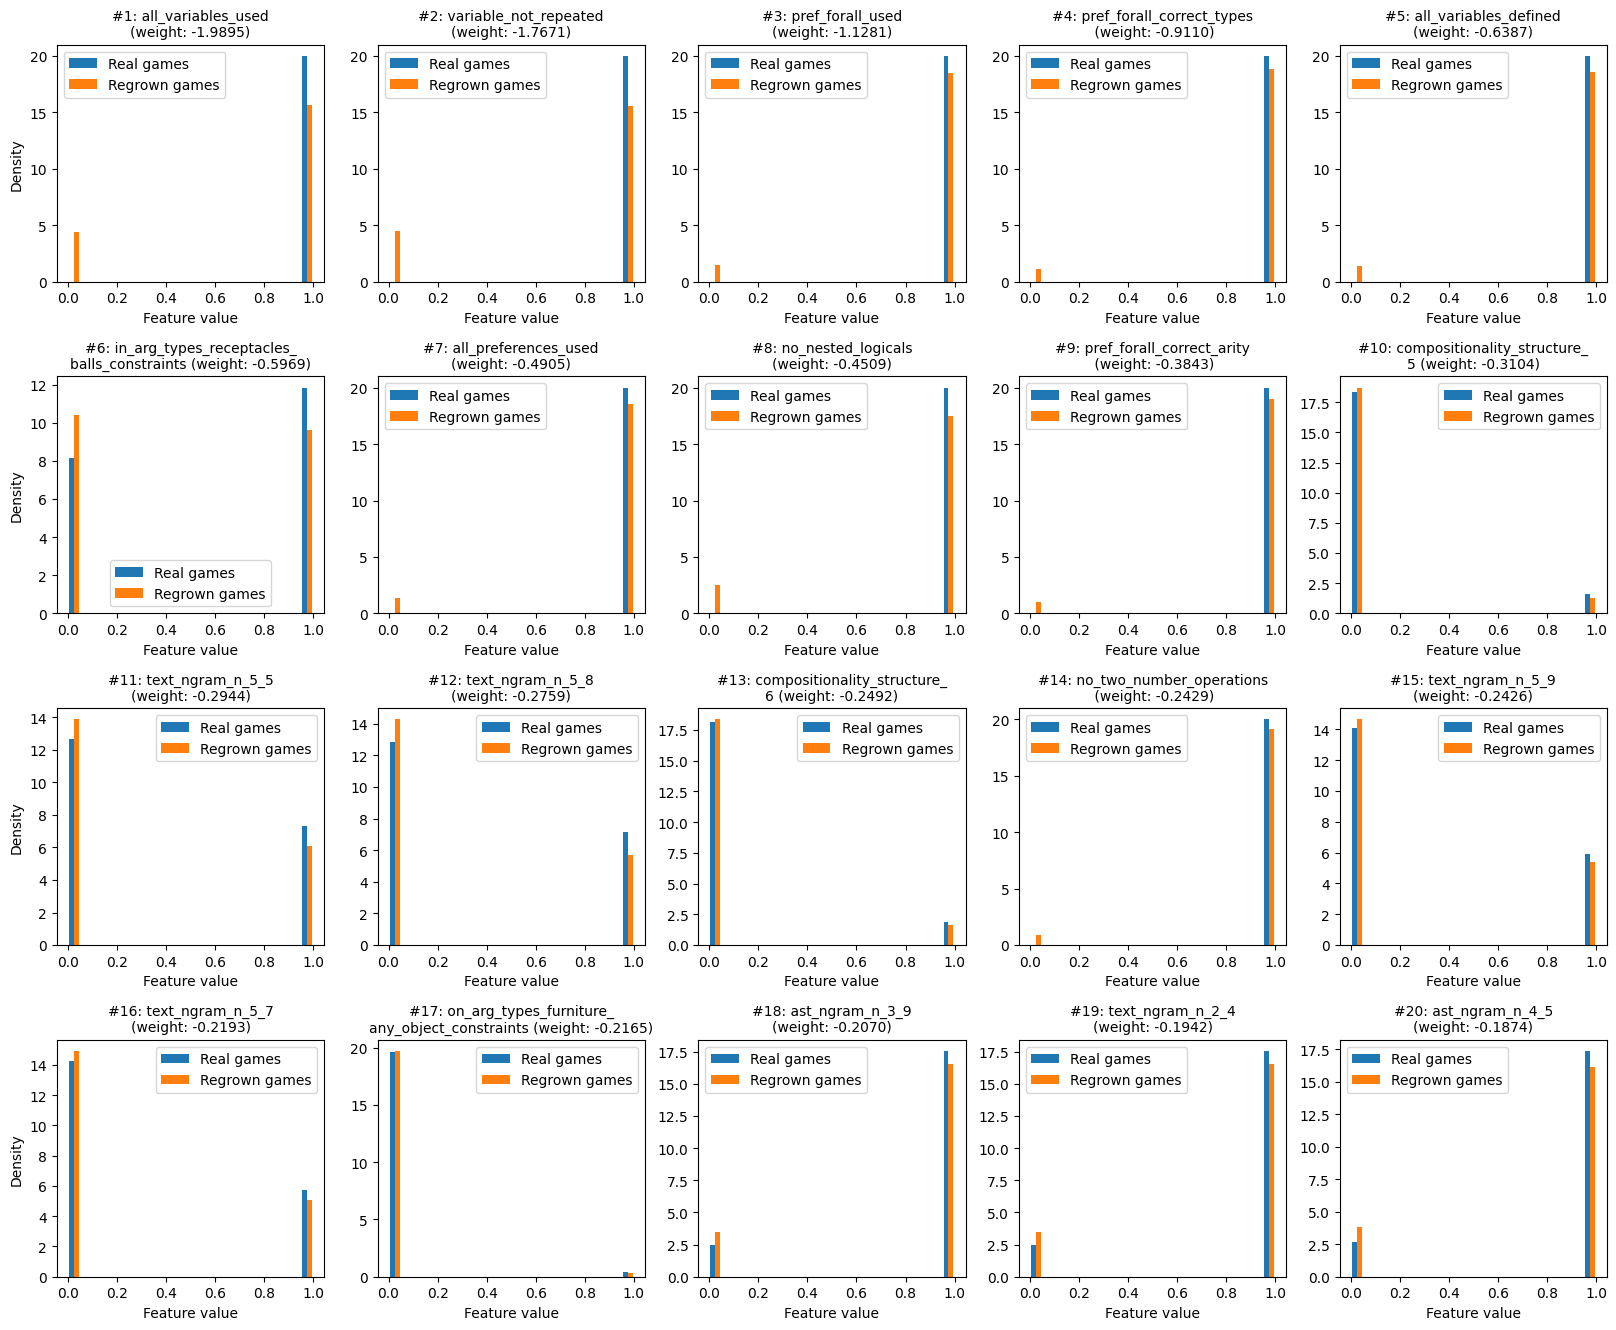

In [9]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

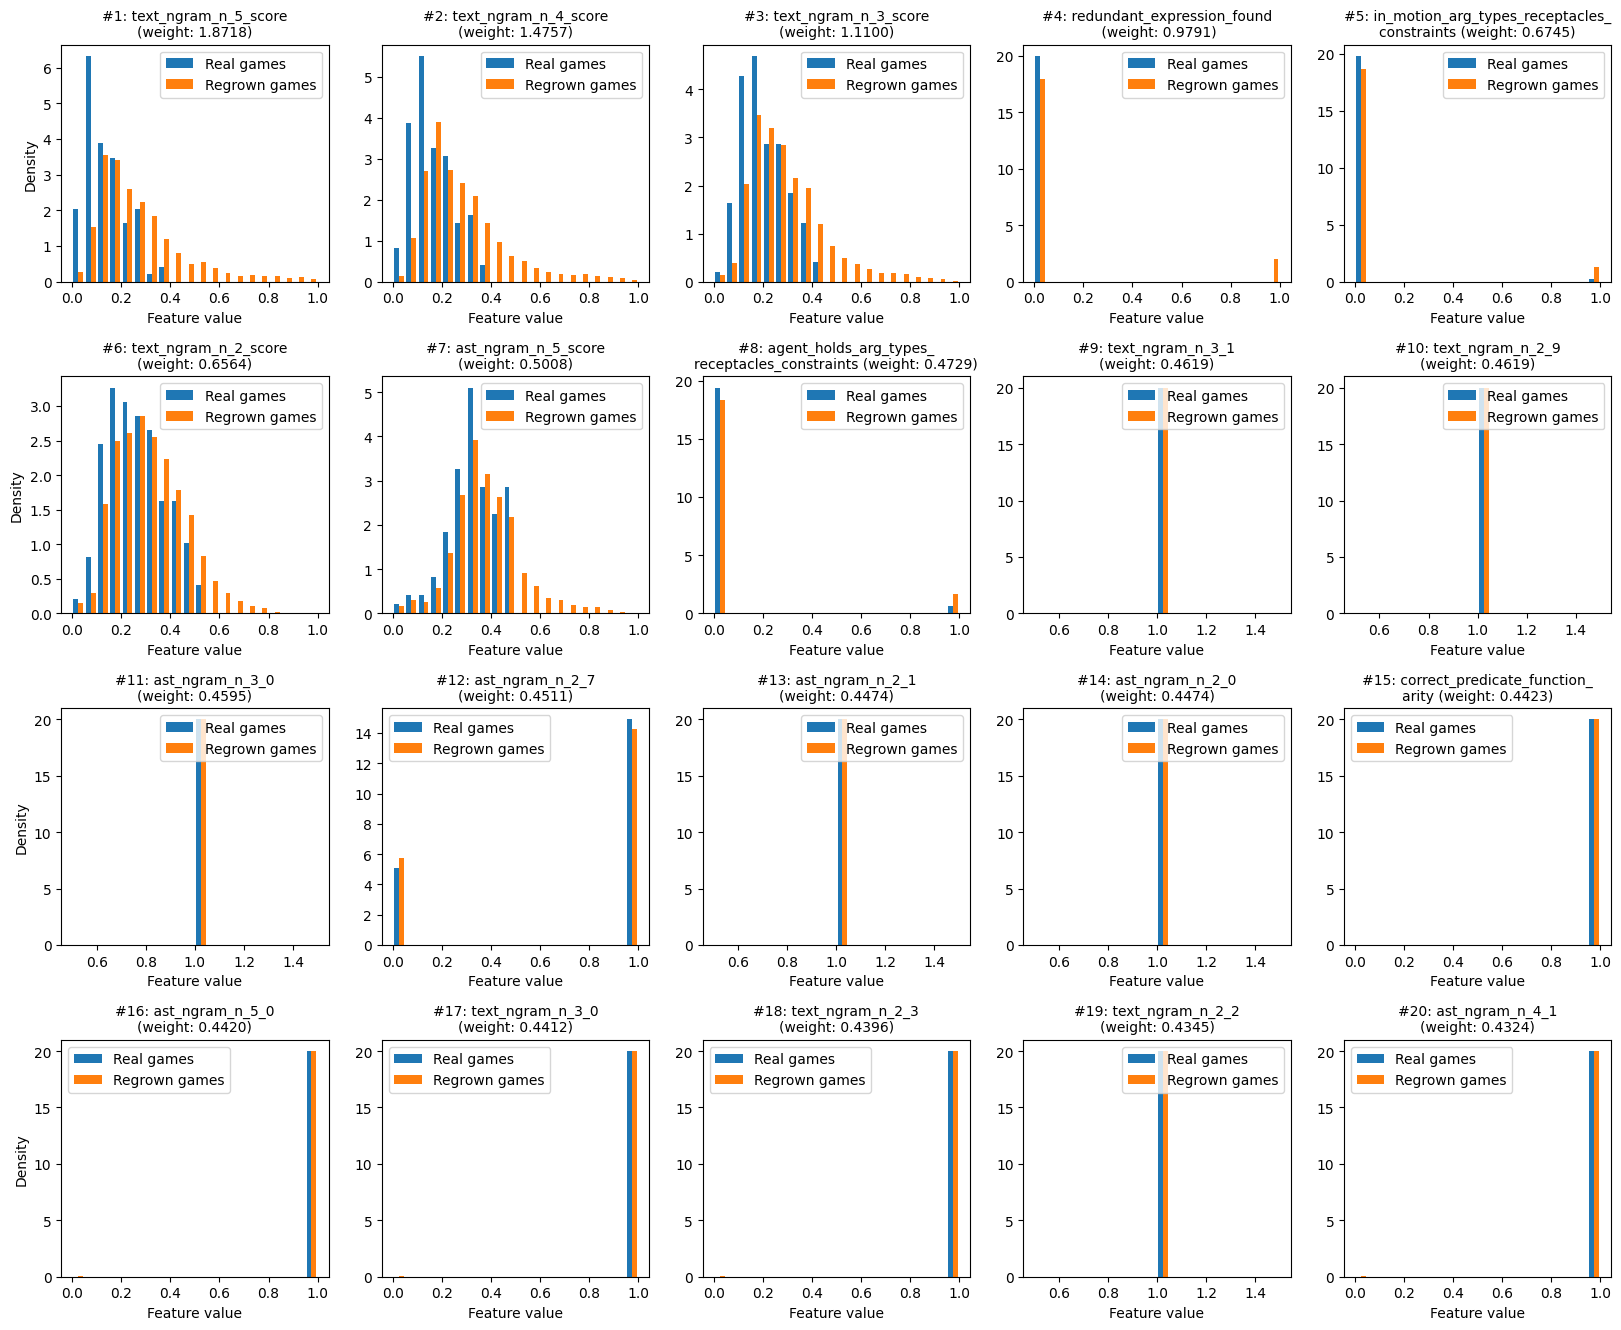

In [10]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [11]:
feature_columns = [c for c in data_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(data_df, feature_columns)
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

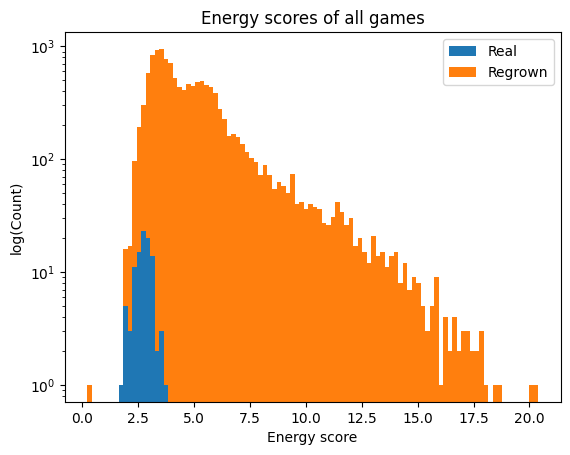

In [12]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [13]:
negatives = full_tensor[:, 1:, :]
negatives_scores = cv_energy_model.transform(negatives).detach()

In [14]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [15]:
torch.topk(score_diffs.ravel(), 10, largest=False)

torch.return_types.topk(
values=tensor([-2.2887, -0.5873, -0.3370, -0.3196, -0.3144, -0.2486, -0.2322, -0.1918,
        -0.1878, -0.1867]),
indices=tensor([ 6435, 11145, 10084,  5036,  9357,  7605,  8334, 10212,  8282,  9158]))

In [16]:
N_NEGATIVES = 20
for index in torch.topk(score_diffs.ravel(), 10, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_texts, display_features_diff=False)
    
    display(Markdown('---'))

/home/gd1279/projects/game-generation-modeling/src/fitness_energy_utils.py:751: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row, col = index // negatives.shape[1], index % negatives.shape[1]


### Energy of real game: 2.498 | Energy of regrown game: 0.209 | Difference: -2.289

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                          | Features decreasing energy (= more real)                |
|-----------------------------------------------------------------------------------|---------------------------------------------------------|
| in_arg_types_receptacles_balls_constraints: **0.597** = (1.000 => 0.000) * -0.597 | ast_ngram_n_2_7: **-0.451** = (1.000 => 0.000) * 0.451  |
| text_ngram_n_5_score: **0.311** = (0.183 => 0.349) * 1.872                        | ast_ngram_n_5_0: **-0.442** = (1.000 => 0.000) * 0.442  |
| text_ngram_n_5_5: **0.294** = (1.000 => 0.000) * -0.294                           | text_ngram_n_3_0: **-0.441** = (1.000 => 0.000) * 0.441 |
| text_ngram_n_5_8: **0.276** = (1.000 => 0.000) * -0.276                           | text_ngram_n_2_3: **-0.440** = (1.000 => 0.000) * 0.440 |
| text_ngram_n_5_9: **0.243** = (1.000 => 0.000) * -0.243                           | ast_ngram_n_4_1: **-0.432** = (1.000 => 0.000) * 0.432  |
| ast_ngram_n_4_5: **0.187** = (1.000 => 0.000) * -0.187                            | ast_ngram_n_3_8: **-0.431** = (1.000 => 0.000) * 0.431  |
| text_ngram_n_5_6: **0.181** = (1.000 => 0.000) * -0.181                           | ast_ngram_n_3_1: **-0.429** = (1.000 => 0.000) * 0.429  |
| text_ngram_n_4_1: **0.173** = (1.000 => 0.000) * -0.173                           | ast_ngram_n_4_0: **-0.426** = (1.000 => 0.000) * 0.426  |
| text_ngram_n_5_3: **0.171** = (1.000 => 0.000) * -0.171                           | text_ngram_n_4_0: **-0.325** = (1.000 => 0.000) * 0.325 |
| ast_ngram_n_5_6: **0.168** = (1.000 => 0.000) * -0.168                            | ast_ngram_n_2_6: **-0.324** = (1.000 => 0.000) * 0.324  |

### Game Diffs

Original game index: 50 | Negative game row: 50 | Negative game col: 35


n,1,(define (game 602a1735bf92e79a5e7cb632-59) (:domain many-objects-room-v1),n,1,(define (game 602a1735bf92e79a5e7cb632-59-35-nd6-rd15) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance ?h door) 1),,6,(< (distance ?h door) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,(:constraints,,11,(:constraints


---

### Energy of real game: 3.167 | Energy of regrown game: 2.580 | Difference: -0.587

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                            | Features decreasing energy (= more real)                                        |
|-------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| max_depth_constraints_2: **0.308** = (0.000 => 1.000) * 0.308                       | ast_ngram_n_2_4: **-0.395** = (1.000 => 0.000) * 0.395                          |
| text_ngram_n_5_score: **0.174** = (0.000 => 0.093) * 1.872                          | ast_ngram_n_2_6: **-0.324** = (1.000 => 0.000) * 0.324                          |
| mean_depth_constraints_2: **0.169** = (0.000 => 1.000) * 0.169                      | ast_ngram_n_2_3: **-0.199** = (1.000 => 0.000) * 0.199                          |
| text_ngram_n_4_score: **0.120** = (0.000 => 0.081) * 1.476                          | max_depth_constraints_3: **-0.174** = (1.000 => 0.000) * 0.174                  |
| node_count_constraints_1: **0.097** = (0.000 => 1.000) * 0.097                      | node_count_constraints_2: **-0.143** = (1.000 => 0.000) * 0.143                 |
| text_ngram_n_3_score: **0.081** = (0.000 => 0.073) * 1.110                          | text_ngram_n_2_1: **-0.107** = (1.000 => 0.000) * 0.107                         |
| distance_arg_types_blocks_blocks_constraints: **0.045** = (1.000 => 0.000) * -0.045 | no_adjacent_once: **-0.106** = (1.000 => 0.000) * 0.106                         |
| on_arg_types_blocks_room_features_constraints: **0.031** = (0.000 => 1.000) * 0.031 | agent_holds_arg_types_blocks_constraints: **-0.091** = (1.000 => 0.000) * 0.091 |
| ast_ngram_n_5_score: **0.018** = (0.016 => 0.052) * 0.501                           | in_motion_arg_types_blocks_constraints: **-0.079** = (1.000 => 0.000) * 0.079   |
| ast_ngram_n_4_score: **0.014** = (0.017 => 0.049) * 0.429                           | ast_ngram_n_4_9: **-0.033** = (1.000 => 0.000) * 0.033                          |

### Game Diffs

Original game index: 87 | Negative game row: 87 | Negative game col: 9


n,1,(define (game 61015f63f9a351d3171a0f98-105) (:domain few-objects-room-v1),n,1,(define (game 61015f63f9a351d3171a0f98-105-9-nd7-rd19) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?c - chair),,4,(forall (?c - chair)
,5,(game-conserved,,5,(game-conserved
,6,(or,,6,(or
,7,(on bed ?c),,7,(on bed ?c)
,8,(adjacent bed ?c),,8,(adjacent bed ?c)
,9,),,9,)
,10,),,10,)
,11,),,11,)


---

### Energy of real game: 2.683 | Energy of regrown game: 2.346 | Difference: -0.337

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                    |
|--------------------------------------------|-------------------------------------------------------------|
|                                            | text_ngram_n_5_score: **-0.150** = (0.360 => 0.280) * 1.872 |
|                                            | text_ngram_n_4_score: **-0.098** = (0.391 => 0.324) * 1.476 |
|                                            | text_ngram_n_3_score: **-0.058** = (0.424 => 0.372) * 1.110 |
|                                            | text_ngram_n_2_score: **-0.032** = (0.519 => 0.471) * 0.656 |

### Game Diffs

Original game index: 78 | Negative game row: 78 | Negative game col: 100


n,1,(define (game 60a6ba026f8bd75b67b23c97-93) (:domain many-objects-room-v1),n,1,(define (game 60a6ba026f8bd75b67b23c97-93-100-nd8-rd1) (:domain many-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference throwBallToBin,,4,(preference throwBallToBin
t,5,(exists (?d - dodgeball ?h - hexagonal_bin),t,5,(exists (?d - golfball ?h - hexagonal_bin)
,6,(then,,6,(then
,7,(once (agent_holds ?d) ),,7,(once (agent_holds ?d) )
,8,(hold (and (not (agent_holds ?d) ) (in_motion ?d) ) ),,8,(hold (and (not (agent_holds ?d) ) (in_motion ?d) ) )
,9,(once (and (not (in_motion ?d) ) (in ?h ?d) ) ),,9,(once (and (not (in_motion ?d) ) (in ?h ?d) ) )
,10,),,10,)
,11,),,11,)


---

### Energy of real game: 2.966 | Energy of regrown game: 2.647 | Difference: -0.320

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                             | Features decreasing energy (= more real)                                      |
|----------------------------------------------------------------------|-------------------------------------------------------------------------------|
| mean_depth_setup_2: **0.184** = (0.000 => 1.000) * 0.184             | ast_ngram_n_3_7: **-0.204** = (1.000 => 0.000) * 0.204                        |
| max_depth_setup_2: **0.150** = (0.000 => 1.000) * 0.150              | mean_depth_setup_3: **-0.166** = (1.000 => 0.000) * 0.166                     |
| adjacent_arg_types_other_setup: **0.085** = (0.000 => 1.000) * 0.085 | node_count_setup_3: **-0.164** = (1.000 => 0.000) * 0.164                     |
| node_count_setup_2: **0.084** = (0.000 => 1.000) * 0.084             | max_depth_setup_3: **-0.153** = (1.000 => 0.000) * 0.153                      |
| text_ngram_n_5_score: **0.062** = (0.077 => 0.110) * 1.872           | ast_ngram_n_3_6: **-0.122** = (1.000 => 0.000) * 0.122                        |
| text_ngram_n_4_score: **0.025** = (0.110 => 0.127) * 1.476           | ast_ngram_n_2_8: **-0.057** = (1.000 => 0.000) * 0.057                        |
| ast_ngram_n_5_score: **0.023** = (0.258 => 0.305) * 0.501            | ast_ngram_n_3_4: **-0.047** = (1.000 => 0.000) * 0.047                        |
| ast_ngram_n_4_3: **0.017** = (1.000 => 0.000) * -0.017               | ast_ngram_n_4_9: **-0.033** = (1.000 => 0.000) * 0.033                        |
| ast_ngram_n_4_score: **0.013** = (0.256 => 0.287) * 0.429            | in_arg_types_building_any_object_setup: **-0.015** = (1.000 => 0.000) * 0.015 |
| text_ngram_n_3_score: **0.012** = (0.153 => 0.164) * 1.110           | ast_ngram_n_3_3: **-0.012** = (1.000 => 0.000) * 0.012                        |

### Game Diffs

Original game index: 39 | Negative game row: 39 | Negative game col: 44


n,1,(define (game 61254c5a6facc8ed023a64de-48) (:domain medium-objects-room-v1),n,1,(define (game 61254c5a6facc8ed023a64de-48-44-nd5-rd17) (:domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?b - building ?h - hexagonal_bin),,4,(exists (?b - building ?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
t,6,(and,t,,
,7,(in ?b ?h),,6,(adjacent ?b ?h)
,8,(>= (building_size ?b) 4),,,
,9,(not,,,
,10,(exists (?g - game_object),,,
,11,(and,,,


---

### Energy of real game: 2.806 | Energy of regrown game: 2.492 | Difference: -0.314

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                   | Features decreasing energy (= more real)                                           |
|------------------------------------------------------------|------------------------------------------------------------------------------------|
| text_ngram_n_5_score: **0.131** = (0.111 => 0.181) * 1.872 | in_arg_types_receptacles_balls_constraints: **-0.597** = (0.000 => 1.000) * -0.597 |
| text_ngram_n_4_score: **0.085** = (0.141 => 0.199) * 1.476 |                                                                                    |
| text_ngram_n_3_score: **0.052** = (0.179 => 0.226) * 1.110 |                                                                                    |
| text_ngram_n_2_score: **0.014** = (0.223 => 0.245) * 0.656 |                                                                                    |

### Game Diffs

Original game index: 73 | Negative game row: 73 | Negative game col: 13


n,1,(define (game 61272733b6c8fe076880e02c-85) (:domain few-objects-room-v1),n,1,(define (game 61272733b6c8fe076880e02c-85-13-nd19-rd1) (:domain few-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(forall (?c - color),,4,(forall (?c - color)
,5,(and,,5,(and
,6,(preference cubeThrownToBin,,6,(preference cubeThrownToBin
,7,(exists (?h - hexagonal_bin ?b - cube_block),,7,(exists (?h - hexagonal_bin ?b - cube_block)
,8,(then,,8,(then
t,9,(once (and (agent_holds ?b) (rug_color_under agent pink) (same_color ?b ?c) (not (exis,t,9,(once (and (agent_holds ?b) (rug_color_under agent pink) (same_color ?b ?c) (not (exis
,>,ts (?ob - cube_block) (in ?h ?ob) ) ) ) ),,>,ts (?ob - beachball) (in ?h ?ob) ) ) ) )
,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) ),,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )


---

### Energy of real game: 2.748 | Energy of regrown game: 2.499 | Difference: -0.249

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                   | Features decreasing energy (= more real)                             |
|------------------------------------------------------------|----------------------------------------------------------------------|
| text_ngram_n_4_score: **0.006** = (0.127 => 0.131) * 1.476 | text_ngram_n_5_9: **-0.243** = (0.000 => 1.000) * -0.243             |
| text_ngram_n_5_score: **0.005** = (0.099 => 0.102) * 1.872 | compositionality_structure_2: **-0.016** = (0.000 => 1.000) * -0.016 |
| text_ngram_n_3_score: **0.004** = (0.163 => 0.167) * 1.110 | ast_ngram_n_5_score: **-0.002** = (0.361 => 0.356) * 0.501           |
| text_ngram_n_2_score: **0.001** = (0.195 => 0.197) * 0.656 | ast_ngram_n_4_score: **-0.002** = (0.335 => 0.331) * 0.429           |
|                                                            | ast_ngram_n_3_score: **-0.002** = (0.417 => 0.412) * 0.379           |
|                                                            | ast_ngram_n_2_score: **-0.001** = (0.422 => 0.419) * 0.206           |

### Game Diffs

Original game index: 59 | Negative game row: 59 | Negative game col: 53


n,1,(define (game 5fbbf3f438be4c025df6cdd4-70) (:domain many-objects-room-v1),n,1,(define (game 5fbbf3f438be4c025df6cdd4-70-53-nd11-rd7) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?c - chair),,4,(forall (?c - chair)
,5,(game-conserved,,5,(game-conserved
,6,(not,,6,(not
,7,(adjacent_side desk front ?c),,7,(adjacent_side desk front ?c)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,(exists (?h - hexagonal_bin ?c - curved_wooden_ramp),,11,(exists (?h - hexagonal_bin ?c - curved_wooden_ramp)


---

### Energy of real game: 3.308 | Energy of regrown game: 3.076 | Difference: -0.232

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                   | Features decreasing energy (= more real)                             |
|------------------------------------------------------------|----------------------------------------------------------------------|
| text_ngram_n_5_score: **0.018** = (0.098 => 0.107) * 1.872 | text_ngram_n_5_9: **-0.243** = (0.000 => 1.000) * -0.243             |
| ast_ngram_n_2_score: **0.002** = (0.418 => 0.429) * 0.206  | compositionality_structure_2: **-0.016** = (0.000 => 1.000) * -0.016 |
| text_ngram_n_4_score: **0.002** = (0.145 => 0.146) * 1.476 |                                                                      |
| text_ngram_n_3_score: **0.001** = (0.196 => 0.197) * 1.110 |                                                                      |
| text_ngram_n_2_score: **0.001** = (0.269 => 0.271) * 0.656 |                                                                      |
| ast_ngram_n_3_score: **0.001** = (0.379 => 0.382) * 0.379  |                                                                      |

### Game Diffs

Original game index: 65 | Negative game row: 65 | Negative game col: 14


n,1,(define (game 5d0ba121619661001a7f4fe6-76) (:domain few-objects-room-v1),n,1,(define (game 5d0ba121619661001a7f4fe6-76-14-nd11-rd7) (:domain few-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(forall (?c - (either pink yellow)),,4,(forall (?c - (either pink yellow))
,5,(and,,5,(and
,6,(preference blockToBinFromRug,,6,(preference blockToBinFromRug
,7,(exists (?b - cube_block ?h - hexagonal_bin),,7,(exists (?b - cube_block ?h - hexagonal_bin)
,8,(then,,8,(then
t,9,(once (and (agent_holds ?b) (rug_color_under agent ?c) ) ),t,9,(once (agent_holds ?b) )
,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) ),,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )
,11,(once (and (not (in_motion ?b) ) (or (in ?h ?b) (exists (?bl - building) (and (in ?bl,,11,(once (and (not (in_motion ?b) ) (or (in ?h ?b) (exists (?bl - building) (and (in ?bl


---

### Energy of real game: 2.883 | Energy of regrown game: 2.691 | Difference: -0.192

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                   | Features decreasing energy (= more real)                             |
|------------------------------------------------------------|----------------------------------------------------------------------|
| text_ngram_n_5_score: **0.023** = (0.238 => 0.250) * 1.872 | text_ngram_n_5_9: **-0.243** = (0.000 => 1.000) * -0.243             |
| text_ngram_n_4_score: **0.021** = (0.276 => 0.290) * 1.476 | compositionality_structure_2: **-0.016** = (0.000 => 1.000) * -0.016 |
| text_ngram_n_3_score: **0.018** = (0.317 => 0.333) * 1.110 | ast_ngram_n_4_score: **-0.004** = (0.365 => 0.357) * 0.429           |
| text_ngram_n_2_score: **0.014** = (0.380 => 0.402) * 0.656 | ast_ngram_n_5_score: **-0.003** = (0.357 => 0.350) * 0.501           |
|                                                            | ast_ngram_n_3_score: **-0.003** = (0.469 => 0.461) * 0.379           |

### Game Diffs

Original game index: 79 | Negative game row: 79 | Negative game col: 100


n,1,(define (game 5cdad620eae6f70019d4e950-94) (:domain many-objects-room-v1),n,1,(define (game 5cdad620eae6f70019d4e950-94-100-nd10-rd7) (:domain many-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(forall (?b - (either dodgeball golfball)),,4,(forall (?b - (either dodgeball golfball))
,5,(and,,5,(and
,6,(preference ballThrownFromDoor,,6,(preference ballThrownFromDoor
,7,(exists (?h - hexagonal_bin),,7,(exists (?h - hexagonal_bin)
,8,(then,,8,(then
,9,(once (and (agent_holds ?b) (adjacent door agent) ) ),,9,(once (and (agent_holds ?b) (adjacent door agent) ) )
,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) ),,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )
,11,(once (and (not (in_motion ?b) ) (in ?h ?b) ) ),,11,(once (and (not (in_motion ?b) ) (in ?h ?b) ) )


---

### Energy of real game: 2.909 | Energy of regrown game: 2.721 | Difference: -0.188

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                   | Features decreasing energy (= more real)                             |
|------------------------------------------------------------|----------------------------------------------------------------------|
| text_ngram_n_5_score: **0.028** = (0.225 => 0.241) * 1.872 | text_ngram_n_5_9: **-0.243** = (0.000 => 1.000) * -0.243             |
| text_ngram_n_4_score: **0.023** = (0.275 => 0.290) * 1.476 | compositionality_structure_2: **-0.016** = (0.000 => 1.000) * -0.016 |
| text_ngram_n_3_score: **0.015** = (0.325 => 0.338) * 1.110 | ast_ngram_n_3_score: **-0.001** = (0.536 => 0.533) * 0.379           |
| text_ngram_n_2_score: **0.006** = (0.419 => 0.429) * 0.656 | ast_ngram_n_5_score: **-0.001** = (0.464 => 0.461) * 0.501           |
| ast_ngram_n_2_score: **0.001** = (0.606 => 0.609) * 0.206  | ast_ngram_n_4_score: **-0.001** = (0.435 => 0.433) * 0.429           |

### Game Diffs

Original game index: 64 | Negative game row: 64 | Negative game col: 90


n,1,(define (game 612fc78547802a3f177e0d53-75) (:domain few-objects-room-v1),n,1,(define (game 612fc78547802a3f177e0d53-75-90-nd9-rd7) (:domain few-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference ballDroppedInBin,,4,(preference ballDroppedInBin
,5,(exists (?b - ball ?h - hexagonal_bin),,5,(exists (?b - ball ?h - hexagonal_bin)
,6,(then,,6,(then
t,7,(once (and (adjacent agent ?h) (agent_holds ?b) ) ),t,7,(once (agent_holds ?b) )
,8,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) ),,8,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )
,9,(once (and (not (in_motion ?b) ) (in ?h ?b) ) ),,9,(once (and (not (in_motion ?b) ) (in ?h ?b) ) )
,10,),,10,)
,11,),,11,)


---

### Energy of real game: 2.615 | Energy of regrown game: 2.428 | Difference: -0.187

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                    |
|--------------------------------------------|-------------------------------------------------------------|
|                                            | text_ngram_n_5_score: **-0.083** = (0.255 => 0.211) * 1.872 |
|                                            | text_ngram_n_4_score: **-0.055** = (0.306 => 0.268) * 1.476 |
|                                            | text_ngram_n_3_score: **-0.032** = (0.345 => 0.316) * 1.110 |
|                                            | text_ngram_n_2_score: **-0.016** = (0.423 => 0.398) * 0.656 |

### Game Diffs

Original game index: 71 | Negative game row: 71 | Negative game col: 70


n,1,(define (game 6172378d423fdf1acdc2d212-82) (:domain many-objects-room-v1),n,1,(define (game 6172378d423fdf1acdc2d212-82-70-nd8-rd1) (:domain many-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference ballThrownToBin,,4,(preference ballThrownToBin
t,5,(exists (?b - ball ?h - hexagonal_bin),t,5,(exists (?b - golfball ?h - hexagonal_bin)
,6,(then,,6,(then
,7,(once (agent_holds ?b) ),,7,(once (agent_holds ?b) )
,8,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) ),,8,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )
,9,(once (and (not (in_motion ?b) ) (in ?h ?b) ) ),,9,(once (and (not (in_motion ?b) ) (in ?h ?b) ) )
,10,),,10,)
,11,),,11,)


---